In [2]:
import torch
import torch.nn as nn
from d2l import torch as d2l

# 汇聚层
再处理图像的时候, 希望可以逐渐降低隐藏表示的空间分辨率、聚集信息, 这样可以在神经网络中层叠的上升, 每一个神经元对其敏感的感受野(输入)越大

计算机视觉中的任务通常和全局的图像问题相关, 并且最后一层的神经元应该对整个输入的全局敏感,也就是最终的结果需要聚合全局信息, 把卷积图层的优势保保留在中间层

同时当检测较底层的特征的时候, 希望保证某种程度上的平移不变性, 比如对于图像 $X$, 进行单像素的移动因该不产生任何影响, 也就是 $Z[i, j] = X[i, j + 1]$, 则新图像 $Z$ 的输出可能不相同

汇聚层(pooling, 池化层)的作用: 降低卷积层对位置的敏感性, 同时降低对空间采样的敏感性(聚集全局图像)

## 最大汇聚层和平均汇聚层
汇聚层运算符使用一个固定形状的窗口组成, 该窗口根据其步幅大小再输入的所有区域中滑动, 并且为固定形状窗口(聚集窗口)遍历的每一个位置计算一个输出 ; 同时池运算是固定的, 通常可以计算汇聚窗口中所有元素的平均值或者最大值, 这些操作对应的汇聚层佳作最大汇聚层和平均汇聚层

比如对于最大汇聚层, 运算过程如下:
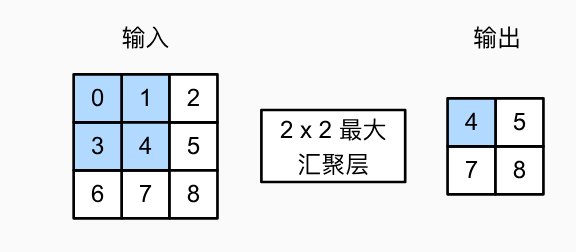

同时汇聚窗口形状为 $p \times q$的汇聚层称为 $p \times q$汇聚层, 汇聚操作称为 $p \times q$汇聚

可以发现, 对于这一种汇聚操作, 无论 $X[i, j]$ 和 $X[i, j + 1]$ 的值是否相同, 汇聚层的输出始终不变(将地看了对于位置和空间采样的敏感性), 同时对于单通道单输出特征而言, 如果输入图像大小为 $h \times w$, 同时汇聚层大小为 $p \times q$, 那么输出大小为 $(h - p + 1) \times (w  - q + 1)$

In [6]:
# 模拟汇聚层
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i:i+p_h, j:j+p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i:i+p_h, j:j+p_w].mean()
    return Y

In [7]:
X = torch.arange(9.0).reshape((3, 3))
pool2d(X, (2, 2)) # 注意汇聚层相当于就是对于输入本身的处理, 没有加权

tensor([[4., 5.],
        [7., 8.]])

In [8]:
pool2d(X, (2, 2), mode='avg')

tensor([[2., 3.],
        [5., 6.]])

## 填充和步幅
其实汇聚层和卷积层具有相似的特点, 无论是填充还是步幅还是多通道属性都是类似的 ; 不同之处仅仅在于对于 "感受野"(作用的指定范围)内的元素的操作不同, 卷积层的操作是加权求和, 汇聚层的操作是最大化或者求解平均值 ; 所以对于输出图像大小的求解方式还是类似于池化层的求解

In [18]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [19]:
# 默认情况下 步幅 = 汇聚窗口大小, 这里设置汇聚窗口大小 kernel_size=(3,3)
pool2d = nn.MaxPool2d(3) # 对应的汇聚层是二维的
pool2d(X)

tensor([[[[10.]]]])

In [20]:
# 指定 padding 和 stride
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
# 宽: 4 + 1*2 - 3 + 2 / 2 = 5 / 2 = 2 
# 高: 4 + 1*2 - 3 + 2 / 2 = 5 / 2 = 2
pool2d(X)  

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [21]:
# torch.cat 再现有维度上拼接, torch.stack 再新创建的维度上拼接
X = torch.cat((X, X + 1), dim=1)
X, X.shape # 模拟双通道的情况

(tensor([[[[ 0.,  1.,  2.,  3.],
           [ 4.,  5.,  6.,  7.],
           [ 8.,  9., 10., 11.],
           [12., 13., 14., 15.]],
 
          [[ 1.,  2.,  3.,  4.],
           [ 5.,  6.,  7.,  8.],
           [ 9., 10., 11., 12.],
           [13., 14., 15., 16.]]]]),
 torch.Size([1, 2, 4, 4]))

In [22]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])